# Importing important libraries

First group contains important libraries for data processing, training and visualization.
Second group contains helping libraries in small tasks.
Third group imports important functions that we build for the system model and training:

1. Environment: contains the UAV system model.
2. agent_Online_DQN: contains the agent, where neural network and training are performed there.
3. buffer: a memory to save agent experience.
4. utils: contains helping function, such as variables, preprocessing and testing.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import deque
import argparse
import glob
import random
from random import randrange
import math
import copy
import random
import itertools
from collections import deque

from Environment import environment
from agent_Online_DQN import DQNAgent
from buffer import ReplayBuffer
from utils import collect_random, get_config



# from k_means_constrained import KMeansConstrained

In [2]:
# Import the variables. If you want to change number of devices, clusters, delta, ... go utils.py and play with get_config function
config = get_config()

# create a random seed to ensure randomness or fix the seed to ensure same figures.
np.random.seed(config.seed)
random.seed(config.seed)
torch.manual_seed(config.seed)

# Create a random positions for the devices. 0 and config.Num_Cells are min and max coordinates.
Dev_Coord = np.random.randint(0, config.Num_Cells, size=(config.M, 2))

# Define the environment. It needs the coordinates and the variables.
env = environment(Dev_Coord,config)

# Search for a GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Epsilon decay variables to ensure exploration more in the beginning of training.
eps = 1.
d_eps = 1 - config.min_eps
steps = 0
total_steps = 0
cntt = 0

# Define independent agents and independent memories
agent = []
buffer = []
for i in range(config.U):
    agent_u = DQNAgent(state_size=env.observation_space.shape,
                 action_size=env.action_space.shape[0],
                 device=device)
    buffer_u = ReplayBuffer(buffer_size=config.buffer_size, batch_size=config.Batch_online, device=device)
    agent.append(agent_u)
    buffer.append(buffer_u)

# collect random data to speed up training
collect_random(env=env, U=config.U, dataset=buffer, num_samples=500)

# Define arrays to save total and individual rewards
Episode_Reward = []
Episode_0_reward = []
Episode_1_reward = []


# Start training
for i in range(1, config.episodes+1):
    state = env.reset() # reset env
    # Initializations
    episode_steps = 0
    rewards = 0
    action = [0] * config.U
    loss = [0] * config.U
    reward_all = np.zeros(config.U)
    
    # Time loop
    while True:
        for u in range(config.U): # get the action for each UAV
            action_u = agent[u].get_action(state, epsilon=eps)
            action[u] = action_u[0]
        steps += 1
        next_state, reward, done = env.step(state,action) # take a step in the env

        for u in range(config.U): # save experience in each buffer
            buffer[u].add(state, [action[u]], reward[u], next_state, done[u])
            reward_all[u] = reward_all[u] + reward[u]
        
        # Update each agent network
        for u in range(config.U):
            if(env.done[u]==0):
                loss[u], bellmann_error_0 = agent[u].learn_dqn(buffer[u].sample())
        
        # Transit to the next state
        state = next_state.copy()
        cntt = cntt + 1

        rewards += env.Total_reward
        
        # Update epsilon
        episode_steps += 1
        eps = max(1 - ((steps*d_eps)/config.eps_frames), config.min_eps)
        if env.DONE:
            break
    
    # Save rewards and print
    Episode_Reward.append(rewards)
    Episode_0_reward.append(reward_all[0])
    Episode_1_reward.append(reward_all[1])

    total_steps += episode_steps
    print("Episode: {} | Reward: {} | reward_u{} | Steps: {}".format(i, rewards, reward_all, steps,))

    

Episode: 1 | Reward: -680.8287500000002 | reward_u[-826.2575 -826.2575] | Steps: 100
Episode: 2 | Reward: -729.6177500000002 | reward_u[-891.1355 -891.1355] | Steps: 200
Episode: 3 | Reward: -728.845 | reward_u[-920.89 -920.89] | Steps: 300
Episode: 4 | Reward: -732.7557499999998 | reward_u[-919.0115 -919.0115] | Steps: 400
Episode: 5 | Reward: -687.5602500000001 | reward_u[-846.5205 -846.5205] | Steps: 500
Episode: 6 | Reward: -698.17025 | reward_u[-826.4405 -826.4405] | Steps: 600
Episode: 7 | Reward: -679.4394999999997 | reward_u[-800.479 -800.479] | Steps: 700
Episode: 8 | Reward: -753.0902500000001 | reward_u[-978.0805 -978.0805] | Steps: 800
Episode: 9 | Reward: -643.5827500000001 | reward_u[-759.0655 -759.0655] | Steps: 900
Episode: 10 | Reward: -709.36925 | reward_u[-869.5385 -869.5385] | Steps: 1000
Episode: 11 | Reward: -741.81325 | reward_u[-884.1265 -884.1265] | Steps: 1100
Episode: 12 | Reward: -743.0567499999999 | reward_u[-888.1135 -888.1135] | Steps: 1200
Episode: 13 | 

Episode: 99 | Reward: -549.9972499999998 | reward_u[-691.1945 -691.1945] | Steps: 9900
Episode: 100 | Reward: -493.99299999999994 | reward_u[-633.586 -633.586] | Steps: 10000
Episode: 101 | Reward: -461.07799999999975 | reward_u[-576.956 -576.956] | Steps: 10100
Episode: 102 | Reward: -450.68924999999996 | reward_u[-540.1785 -540.1785] | Steps: 10200
Episode: 103 | Reward: -477.2122499999999 | reward_u[-614.2245 -614.2245] | Steps: 10300
Episode: 104 | Reward: -482.791 | reward_u[-602.482 -602.482] | Steps: 10400
Episode: 105 | Reward: -562.83375 | reward_u[-744.0675 -744.0675] | Steps: 10500
Episode: 106 | Reward: -462.51325 | reward_u[-558.3265 -558.3265] | Steps: 10600
Episode: 107 | Reward: -484.08250000000004 | reward_u[-619.165 -619.165] | Steps: 10700
Episode: 108 | Reward: -462.21225000000004 | reward_u[-580.6245 -580.6245] | Steps: 10800
Episode: 109 | Reward: -495.47249999999985 | reward_u[-624.045 -624.045] | Steps: 10900
Episode: 110 | Reward: -483.0542500000001 | reward_u[

Episode: 195 | Reward: -459.61575000000005 | reward_u[-545.4315 -545.4315] | Steps: 19500
Episode: 196 | Reward: -531.9145 | reward_u[-613.429 -613.429] | Steps: 19600
Episode: 197 | Reward: -484.25049999999993 | reward_u[-589.201 -589.201] | Steps: 19700
Episode: 198 | Reward: -515.3037500000002 | reward_u[-602.6075 -602.6075] | Steps: 19800
Episode: 199 | Reward: -489.54474999999985 | reward_u[-589.5895 -589.5895] | Steps: 19900
Episode: 200 | Reward: -482.51075 | reward_u[-579.0215 -579.0215] | Steps: 20000


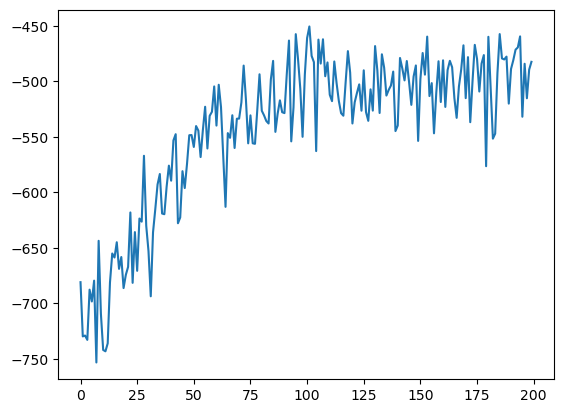

In [3]:
plt.plot(Episode_Reward)
plt.show()
